In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape, Permute

from PIL import Image

Using TensorFlow backend.


# Tiny YOLO v1

In [2]:
def yolo(shape):
    model = Sequential()
    model.add(Convolution2D(16, 3, 3,input_shape=shape,border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(32,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(64,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(128,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(256,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(512,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1470))
    return model

In [3]:
# Helper function to load weights from weights-file into YOLO model
def load_weights(model,yolo_weight_file):
                
    data = np.fromfile(yolo_weight_file,np.float32)
    data=data[4:]
    
    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            bia = data[index:index+np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index+np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker,bia])

In [4]:
# Load the initial model
keras.backend.set_image_dim_ordering('th')
shape = (3,448,448)
model = yolo(shape)
print "Theano mode summary: \n",model.summary()
load_weights(model,'./yolo-tiny.weights')

Theano mode summary: 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
_____________________________________________________________________

In [7]:
# YOLO Part 1
def yoloP1(shape):
    model = Sequential()
    model.add(Convolution2D(16, 3, 3,input_shape=shape,border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(32,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(64,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(128,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(256,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(512,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    return model

# YOLO Part 3
def yoloP3():
    model = Sequential()
    model.add(Dense(256,input_shape=(50176,)))
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1470))
    return model

In [8]:
# Let us get Theano backend edition of Yolo Parts 1 and 3
model_p1_th = yoloP1(shape)
model_p3_th = yoloP3()
# Tensorflow backend edition
keras.backend.set_image_dim_ordering('tf')
shape = (448,448,3)
model_p1 = yoloP1(shape)
model_p3 = yoloP3()
model_full = yolo(shape)

# Check model summaries

In [9]:
model_p1_th.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_10 (Convolution2D) (None, 16, 448, 448)  448         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
leakyrelu_11 (LeakyReLU)         (None, 16, 448, 448)  0           convolution2d_10[0][0]           
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_11[0][0]               
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 32, 224, 224)  4640        maxpooling2d_7[0][0]             
___________________________________________________________________________________________

In [10]:
model_p1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_19 (Convolution2D) (None, 448, 448, 16)  448         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
leakyrelu_21 (LeakyReLU)         (None, 448, 448, 16)  0           convolution2d_19[0][0]           
____________________________________________________________________________________________________
maxpooling2d_13 (MaxPooling2D)   (None, 224, 224, 16)  0           leakyrelu_21[0][0]               
____________________________________________________________________________________________________
convolution2d_20 (Convolution2D) (None, 224, 224, 32)  4640        maxpooling2d_13[0][0]            
___________________________________________________________________________________________

In [11]:
model_p3_th.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 256)           12845312    dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 4096)          1052672     dense_4[0][0]                    
____________________________________________________________________________________________________
leakyrelu_20 (LeakyReLU)         (None, 4096)          0           dense_5[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 1470)          6022590     leakyrelu_20[0][0]               
Total params: 19,920,574
Trainable params: 19,920,574
Non-trainable params: 0
_____________

In [12]:
model_p3.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_7 (Dense)                  (None, 256)           12845312    dense_input_2[0][0]              
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 4096)          1052672     dense_7[0][0]                    
____________________________________________________________________________________________________
leakyrelu_30 (LeakyReLU)         (None, 4096)          0           dense_8[0][0]                    
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 1470)          6022590     leakyrelu_30[0][0]               
Total params: 19,920,574
Trainable params: 19,920,574
Non-trainable params: 0
_____________

In [13]:
model_full.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_28 (Convolution2D) (None, 448, 448, 16)  448         convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
leakyrelu_31 (LeakyReLU)         (None, 448, 448, 16)  0           convolution2d_28[0][0]           
____________________________________________________________________________________________________
maxpooling2d_19 (MaxPooling2D)   (None, 224, 224, 16)  0           leakyrelu_31[0][0]               
____________________________________________________________________________________________________
convolution2d_29 (Convolution2D) (None, 224, 224, 32)  4640        maxpooling2d_19[0][0]            
___________________________________________________________________________________________

## Transfer weights from Theano's model to TensorFlow's model_full

In [14]:
# Transfer weights from Theano model to TensorFlow model_full
for th_layer,tf_layer in zip(model.layers,model_full.layers):
    if th_layer.__class__.__name__ == 'Convolution2D':
        kernel, bias = th_layer.get_weights()
        kernel = np.transpose(kernel,(2,3,1,0))
        tf_layer.set_weights([kernel,bias])
    else:
        tf_layer.set_weights(th_layer.get_weights())

# Test: Theano's model output vs. TensorFlow's model_full output

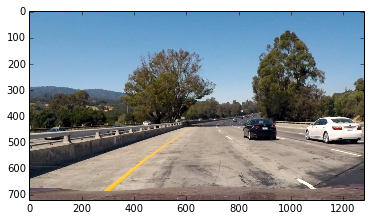

In [15]:
# Read an image and pre-process it
im = cv2.imread('test1.jpg')
plt.imshow(im[:,:,::-1])
plt.show()
im = cv2.resize(im,(448,448))

imPIL = Image.fromarray(im)

im = 2*im.astype(np.float32)/255. - 1
im = np.reshape(im,(1,448,448,3))
im_th = np.transpose(im,(0,3,1,2))

In [16]:
# Theano
output_th = model.predict(im_th)
# TensorFlow
output_tf = model_full.predict(im)

# Distance between two predictions
print 'Difference between two outputs:\nSum of Difference =', np.sum(output_th-output_tf),'\n2-norm of difference =',np.linalg.norm(output_th-output_tf)

Difference between two outputs:
Sum of Difference = 23.2752 
2-norm of difference = 3.84388


The differences calculated above show that the 2 models are giving different output for same type of input. Hence we are splitting the network into three individual parts.

# YOLO Part 1

In [17]:
# Theano
model_p1_th.layers[0].set_weights(model.layers[0].get_weights())
model_p1_th.layers[3].set_weights(model.layers[3].get_weights())
model_p1_th.layers[6].set_weights(model.layers[6].get_weights())
model_p1_th.layers[9].set_weights(model.layers[9].get_weights())
model_p1_th.layers[12].set_weights(model.layers[12].get_weights())
model_p1_th.layers[15].set_weights(model.layers[15].get_weights())
model_p1_th.layers[18].set_weights(model.layers[18].get_weights())
model_p1_th.layers[20].set_weights(model.layers[20].get_weights())
model_p1_th.layers[22].set_weights(model.layers[22].get_weights())

In [19]:
# TensorFlow
model_p1.layers[0].set_weights(model_full.layers[0].get_weights())
model_p1.layers[3].set_weights(model_full.layers[3].get_weights())
model_p1.layers[6].set_weights(model_full.layers[6].get_weights())
model_p1.layers[9].set_weights(model_full.layers[9].get_weights())
model_p1.layers[12].set_weights(model_full.layers[12].get_weights())
model_p1.layers[15].set_weights(model_full.layers[15].get_weights())
model_p1.layers[18].set_weights(model_full.layers[18].get_weights())
model_p1.layers[20].set_weights(model_full.layers[20].get_weights())
model_p1.layers[22].set_weights(model_full.layers[22].get_weights())

In [20]:
# Theano
output_th = model_p1_th.predict(im_th)
# TensorFlow
output_tf = model_p1.predict(im)

# Dimensions of output_th and output_tf are different, so apply transpose on output_th
output_thT = np.transpose(output_th,(0,2,3,1))

# Distance between two predictions
print 'Difference between two outputs:\nSum of Difference =', np.sum(output_thT-output_tf),'\n2-norm of difference =',np.linalg.norm(output_thT-output_tf)

Difference between two outputs:
Sum of Difference = 0.0 
2-norm of difference = 0.0


The differences are zero. Hence, we successfully converted Part 1 of YOLO, let us convert Part 3.

# YOLO Part 3

In [21]:
# Theano
model_p3_th.layers[0].set_weights(model.layers[25].get_weights())
model_p3_th.layers[1].set_weights(model.layers[26].get_weights())
model_p3_th.layers[3].set_weights(model.layers[28].get_weights())

In [22]:
# TensorFlow
model_p3.layers[0].set_weights(model.layers[25].get_weights())
model_p3.layers[1].set_weights(model.layers[26].get_weights())
model_p3.layers[3].set_weights(model.layers[28].get_weights())

In [23]:
# Design the input
input_p3 = np.reshape(np.ndarray.flatten(output_th),(1,50176))

# Theano
output_th = model_p3_th.predict(input_p3)
# TensorFlow
output_tf = model_p3.predict(input_p3)

# Distance between two predictions
print 'Difference between two outputs:\nSum of Difference =', np.sum(output_th-output_tf),'\n2-norm of difference =',np.linalg.norm(output_th-output_tf)

Difference between two outputs:
Sum of Difference = 0.0 
2-norm of difference = 0.0


In [24]:
# A simple test to check Yolo Part 3 output with overall model output
output_th = model.predict(im_th)

# Distance between two predictions
print 'Difference between two outputs:\nSum of Difference =', np.sum(output_th-output_tf),'\n2-norm of difference =',np.linalg.norm(output_th-output_tf)

Difference between two outputs:
Sum of Difference = 0.0 
2-norm of difference = 0.0


Looks like we have successfully designed Parts 1 and 3 of Tiny YOLO v1. Now let us move to Part 2!

# YOLO Part 2

Let us first understand the flatten operation

In [25]:
# Let us build a simple 3(width) x 3(height) x 3(depth) matrix and assume it as an output from Part 1
A = np.reshape(np.asarray([i for i in range(1,10)]),(3,3))
B = A + 10
C = A + 100

print 'A =\n',A,'\n\nB =\n',B,'\n\nC =\n',C

part1_output_tf = np.dstack((A,B,C))
print '\n\nTensorFlow\'s model_p1 output (assume) = \n',part1_output_tf

part1_output_th = np.transpose(part1_output_tf,(2,0,1))
print '\n\nTheano\'s model_p1_th output (assume) = \n',part1_output_th

print '\n\nDesired input for model_p3 =\n', part1_output_th.flatten()
print '\n\nActual input for model_p3 =\n', part1_output_tf.flatten()

A =
[[1 2 3]
 [4 5 6]
 [7 8 9]] 

B =
[[11 12 13]
 [14 15 16]
 [17 18 19]] 

C =
[[101 102 103]
 [104 105 106]
 [107 108 109]]


TensorFlow's model_p1 output (assume) = 
[[[  1  11 101]
  [  2  12 102]
  [  3  13 103]]

 [[  4  14 104]
  [  5  15 105]
  [  6  16 106]]

 [[  7  17 107]
  [  8  18 108]
  [  9  19 109]]]


Theano's model_p1_th output (assume) = 
[[[  1   2   3]
  [  4   5   6]
  [  7   8   9]]

 [[ 11  12  13]
  [ 14  15  16]
  [ 17  18  19]]

 [[101 102 103]
  [104 105 106]
  [107 108 109]]]


Desired input for model_p3 =
[  1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18  19
 101 102 103 104 105 106 107 108 109]


Actual input for model_p3 =
[  1  11 101   2  12 102   3  13 103   4  14 104   5  15 105   6  16 106
   7  17 107   8  18 108   9  19 109]


We can clearly observe that there is huge variation between desired and actual inputs to Part 3 by applying simple Flatten. So how are we going to solve this issue? By using CoreMLTools Neural Network Builder

In [26]:
import coremltools
from coremltools.models import datatypes
from coremltools.models.neural_network import NeuralNetworkBuilder

input_dim = (1024,7,7)
output_dim = (50176,)
input_features = [('yolo_p1_out', datatypes.Array(*input_dim))]
output_features = [('yolo_p2_out', datatypes.Array(*output_dim))]
builder_model_p2 = NeuralNetworkBuilder(input_features,output_features)

builder_model_p2.add_flatten(mode=0,name='flatten_layer',input_name='yolo_p1_out',output_name='yolo_p2_out')
coreml_model_p2 = coremltools.models.MLModel(builder_model_p2.spec)

In [27]:
# Keras equivalent of YOLO Part 2
def yoloP2():
    model = Sequential()
    model.add(Permute((2,3,1),input_shape=(7,7,1024))) #(1,2,3)-x,(2,3,1)-y,(3,1,2)-x,(1,3,2)-x,(2,1,3)-x,(3,2,1)-x
    model.add(Flatten())
    return model

model_p2 = yoloP2()
coreml_model_p2_v2 = coremltools.converters.keras.convert(model_p2,input_names='yolo_p1_out',output_names='yolo_p2_out')

0 : permute_input_1, <keras.engine.topology.InputLayer object at 0x115183590>
1 : permute_1, <keras.layers.core.Permute object at 0x115183550>
2 : flatten_3, <keras.layers.core.Flatten object at 0x1151838d0>


# CoreML model of YOLO Parts 1 & 3

In [28]:
scale = 2/255.
coreml_model_p1 = coremltools.converters.keras.convert(model_p1,
                                                       input_names = 'image',
                                                       output_names = 'yolo_p1_out',
                                                       image_input_names = 'image',
                                                       image_scale = scale,
                                                       red_bias = -1.0,
                                                       green_bias = -1.0,
                                                       blue_bias = -1.0)

0 : convolution2d_input_3, <keras.engine.topology.InputLayer object at 0x1129f0e10>
1 : convolution2d_19, <keras.layers.convolutional.Convolution2D object at 0x1129a1350>
2 : leakyrelu_21, <keras.layers.advanced_activations.LeakyReLU object at 0x113053d50>
3 : maxpooling2d_13, <keras.layers.pooling.MaxPooling2D object at 0x112a3ea50>
4 : convolution2d_20, <keras.layers.convolutional.Convolution2D object at 0x112a2dc90>
5 : leakyrelu_22, <keras.layers.advanced_activations.LeakyReLU object at 0x112a2df50>
6 : maxpooling2d_14, <keras.layers.pooling.MaxPooling2D object at 0x1130ada90>
7 : convolution2d_21, <keras.layers.convolutional.Convolution2D object at 0x11308ead0>
8 : leakyrelu_23, <keras.layers.advanced_activations.LeakyReLU object at 0x1131042d0>
9 : maxpooling2d_15, <keras.layers.pooling.MaxPooling2D object at 0x113104810>
10 : convolution2d_22, <keras.layers.convolutional.Convolution2D object at 0x1130e6950>
11 : leakyrelu_24, <keras.layers.advanced_activations.LeakyReLU object a

In [29]:
coreml_model_p3 = coremltools.converters.keras.convert(model_p3,input_names='yolo_p2_out',output_names='output')

0 : dense_input_2, <keras.engine.topology.InputLayer object at 0x1132a9190>
1 : dense_7, <keras.layers.core.Dense object at 0x1132e3290>
2 : dense_8, <keras.layers.core.Dense object at 0x11331e510>
3 : leakyrelu_30, <keras.layers.advanced_activations.LeakyReLU object at 0x113369550>
4 : dense_9, <keras.layers.core.Dense object at 0x113369390>


# Tests on CoreML models of Parts 1, 2 & 3

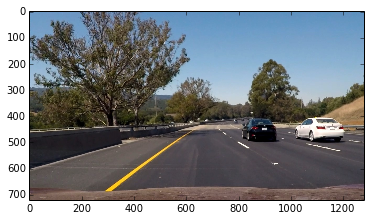

In [30]:
# Read an image and pre-process it
im = cv2.imread('test6.jpg')
plt.imshow(im[:,:,::-1])
plt.show()
im = cv2.resize(im,(448,448))

imPIL = Image.fromarray(im)

im = 2*im.astype(np.float32)/255. - 1
im = np.reshape(im,(1,448,448,3))
im_th = np.transpose(im,(0,3,1,2))

In [31]:
p1_out = coreml_model_p1.predict({'image': imPIL})
model_p1_out = model_p1.predict(im)
model_p1_outT = np.reshape(np.transpose(model_p1_out,(0,3,1,2)),(1024,7,7))
print np.linalg.norm(p1_out['yolo_p1_out']-model_p1_outT)

2.83989981336e-05


In [32]:
p2_out = coreml_model_p2.predict(p1_out)
model_p2_out = model_p1_outT.flatten()
print np.linalg.norm(p2_out['yolo_p2_out']-model_p2_out)

p2v2_out = coreml_model_p2_v2.predict(p1_out)
print np.linalg.norm(p2v2_out['yolo_p2_out']-model_p2_out)

2.83989981336e-05
2.83989981336e-05


In [33]:
p3_out = coreml_model_p3.predict(p2_out)
model_p3_out = model_p3.predict(np.reshape(model_p2_out,(1,50176)))
print np.linalg.norm(p3_out['output']-model_p3_out)

p3_out = coreml_model_p3.predict(p2v2_out)
print np.linalg.norm(p3_out['output']-model_p3_out)

8.68040602098e-06
8.68040602098e-06


In [34]:
model_p3_out

array([[ 0.0585956 ,  0.00641678,  0.04367319, ...,  0.36981058,
         0.21922928,  0.34738636]], dtype=float32)

In [35]:
p3_out['output']

array([ 0.05859551,  0.00641683,  0.04367314, ...,  0.36981058,
        0.21922916,  0.3473863 ])

# Generate CoreML models for Parts 1, 2 & 3

In [36]:
coreml_model_p1.author = 'Sri Raghu Malireddi'
coreml_model_p1.license = 'MIT'
coreml_model_p1.short_description = 'Yolo - Object Detection - Part 1'
coreml_model_p1.input_description['image'] = 'Images from camera in CVPixelBuffer'
coreml_model_p1.output_description['yolo_p1_out'] = 'Tiny YOLO Part 1 Output'
coreml_model_p1.save('TinyYOLOv1P1.mlmodel')

In [37]:
coreml_model_p2.author = 'Sri Raghu Malireddi'
coreml_model_p2.license = 'MIT'
coreml_model_p2.short_description = 'Yolo - Object Detection - Part 2'
coreml_model_p2.input_description['yolo_p1_out'] = 'Tiny YOLO Part 1 Output'
coreml_model_p2.output_description['yolo_p2_out'] = 'Tiny YOLO Part 2 Output'
coreml_model_p2.save('TinyYOLOv1P2.mlmodel')

In [38]:
coreml_model_p3.author = 'Sri Raghu Malireddi'
coreml_model_p3.license = 'MIT'
coreml_model_p3.short_description = 'Yolo - Object Detection - Part 3'
coreml_model_p3.input_description['yolo_p2_out'] = 'Tiny YOLO Part 2 Output'
coreml_model_p3.output_description['output'] = 'Output to compute boxes during Post-processing'
coreml_model_p3.save('TinyYOLOv1P3.mlmodel')

# Combine YOLO Parts 1, 2 and 3 & Test

In [39]:
from coremltools.models.pipeline import Pipeline

input_dim = (448,448,3)
output_dim = (1470,)

input_features = [('image', datatypes.Array(*input_dim))]
output_features = [('output', datatypes.Array(*output_dim))]

yolo_pipeline = Pipeline(input_features, output_features)
yolo_pipeline.add_model(coreml_model_p1)
yolo_pipeline.add_model(coreml_model_p2_v2)
yolo_pipeline.add_model(coreml_model_p3)

In [40]:
yolo_model = coremltools.models.MLModel(yolo_pipeline.spec)

In [41]:
out = yolo_model.predict({'image': imPIL})
print np.linalg.norm(out['output']-model_p3_out)

8.68040602098e-06
The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [33]:
yolo_model.author = 'Sri Raghu Malireddi'
yolo_model.license = 'MIT'
yolo_model.short_description = 'Yolo - Object Detection'
yolo_model.input_description['image'] = 'Images from camera in CVPixelBuffer'
yolo_model.output_description['output'] = 'Output to compute boxes during Post-processing'
yolo_model.save('TinyYOLOv1.mlmodel')

In [42]:
def yoloP1P2P3(shape):
    model = Sequential()
    model.add(Convolution2D(16, 3, 3,input_shape=shape,border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(32,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(64,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(128,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(256,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(512,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Permute((2,3,1)))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1470))
    return model

model_p1p2p3 = yoloP1P2P3(shape)

In [43]:
# TensorFlow
model_p1p2p3.layers[0].set_weights(model_full.layers[0].get_weights())
model_p1p2p3.layers[3].set_weights(model_full.layers[3].get_weights())
model_p1p2p3.layers[6].set_weights(model_full.layers[6].get_weights())
model_p1p2p3.layers[9].set_weights(model_full.layers[9].get_weights())
model_p1p2p3.layers[12].set_weights(model_full.layers[12].get_weights())
model_p1p2p3.layers[15].set_weights(model_full.layers[15].get_weights())
model_p1p2p3.layers[18].set_weights(model_full.layers[18].get_weights())
model_p1p2p3.layers[20].set_weights(model_full.layers[20].get_weights())
model_p1p2p3.layers[22].set_weights(model_full.layers[22].get_weights())
model_p1p2p3.layers[26].set_weights(model_full.layers[25].get_weights())
model_p1p2p3.layers[27].set_weights(model_full.layers[26].get_weights())
model_p1p2p3.layers[29].set_weights(model_full.layers[28].get_weights())

In [44]:
coreml_model_p1p2p3 = coremltools.converters.keras.convert(model_p1p2p3,
                                                       input_names = 'image',
                                                       output_names = 'output',
                                                       image_input_names = 'image',
                                                       image_scale = scale,
                                                       red_bias = -1.0,
                                                       green_bias = -1.0,
                                                       blue_bias = -1.0)

0 : convolution2d_input_5, <keras.engine.topology.InputLayer object at 0x1154dee10>
1 : convolution2d_37, <keras.layers.convolutional.Convolution2D object at 0x1154deed0>
2 : leakyrelu_41, <keras.layers.advanced_activations.LeakyReLU object at 0x113841f90>
3 : maxpooling2d_25, <keras.layers.pooling.MaxPooling2D object at 0x113bab390>
4 : convolution2d_38, <keras.layers.convolutional.Convolution2D object at 0x113bab290>
5 : leakyrelu_42, <keras.layers.advanced_activations.LeakyReLU object at 0x113c39490>
6 : maxpooling2d_26, <keras.layers.pooling.MaxPooling2D object at 0x113c39810>
7 : convolution2d_39, <keras.layers.convolutional.Convolution2D object at 0x113bc2c90>
8 : leakyrelu_43, <keras.layers.advanced_activations.LeakyReLU object at 0x115962cd0>
9 : maxpooling2d_27, <keras.layers.pooling.MaxPooling2D object at 0x113c1c990>
10 : convolution2d_40, <keras.layers.convolutional.Convolution2D object at 0x116b00350>
11 : leakyrelu_44, <keras.layers.advanced_activations.LeakyReLU object a

In [45]:
out = coreml_model_p1p2p3.predict({'image': imPIL})
print np.linalg.norm(out['output']-model_p3_out)

8.68040602098e-06


In [46]:
coreml_model_p1p2p3.author = 'Sri Raghu Malireddi'
coreml_model_p1p2p3.license = 'MIT'
coreml_model_p1p2p3.short_description = 'Yolo - Object Detection'
coreml_model_p1p2p3.input_description['image'] = 'Images from camera in CVPixelBuffer'
coreml_model_p1p2p3.output_description['output'] = 'Output to compute boxes during Post-processing'
coreml_model_p1p2p3.save('TinyYOLOv1.mlmodel')

In [33]:
coreml_model_p1p2v2 = coremltools.converters.keras.convert(model_p1p2v2,
                                                       input_names = 'image',
                                                       output_names = 'yolo_p1p2_out',
                                                       image_input_names = 'image',
                                                       image_scale = scale,
                                                       red_bias = -1.0,
                                                       green_bias = -1.0,
                                                       blue_bias = -1.0)

0 : conv2d_55_input, <keras.engine.topology.InputLayer object at 0x118db04d0>
1 : conv2d_55, <keras.layers.convolutional.Conv2D object at 0x118db0510>
2 : leaky_re_lu_59, <keras.layers.advanced_activations.LeakyReLU object at 0x118c69890>
3 : max_pooling2d_37, <keras.layers.pooling.MaxPooling2D object at 0x118d80dd0>
4 : conv2d_56, <keras.layers.convolutional.Conv2D object at 0x118d94450>
5 : leaky_re_lu_60, <keras.layers.advanced_activations.LeakyReLU object at 0x118db0b50>
6 : max_pooling2d_38, <keras.layers.pooling.MaxPooling2D object at 0x118db0290>
7 : conv2d_57, <keras.layers.convolutional.Conv2D object at 0x118c2cf90>
8 : leaky_re_lu_61, <keras.layers.advanced_activations.LeakyReLU object at 0x12488aa90>
9 : max_pooling2d_39, <keras.layers.pooling.MaxPooling2D object at 0x118e47750>
10 : conv2d_58, <keras.layers.convolutional.Conv2D object at 0x1249139d0>
11 : leaky_re_lu_62, <keras.layers.advanced_activations.LeakyReLU object at 0x1248f8f50>
12 : max_pooling2d_40, <keras.layers

In [34]:
p1p2_out = coreml_model_p1p2.predict({'image': imPIL})
print p1p2_out

{u'yolo_p1p2_out': array([ 0.00651137,  0.01280184, -0.00066207, ...,  0.00371771,
       -0.0032423 ,  0.01790334])}


In [37]:
p1p2v2_out = coreml_model_p1p2v2.predict({'image': imPIL})
print p1p2v2_out['yolo_p1p2_out'].flatten()

(7, 7, 1024)


In [59]:
test = p1p2_out['yolo_p1p2_out']
test = np.reshape(test,(7,7,1024))
test = np.transpose(test,(2,0,1))
test.flatten()

array([ 0.00651137, -0.00052901, -0.0014269 , ...,  0.01689948,
        0.01641578,  0.01790334])

In [90]:
def yoloP2():
    model = Sequential()
    model.add(Permute((2,3,1),input_shape=(7,7,1024)))
    model.add(Flatten())
    return model

model_p2 = yoloP2()
model_p1_out = model_p1.predict(im)
model_p2_out = model_p2.predict(model_p1_out)
print np.linalg.norm(model_p2_out.flatten()-np.transpose(model_p1_out,(0,3,1,2)).flatten())

3.64758


In [91]:
coreml_model_p2v2 = coremltools.converters.keras.convert(model_p2,input_names='yolo_p1_out',output_names='yolo_p2_out')

0 : permute_14_input, <keras.engine.topology.InputLayer object at 0x173c1af10>
1 : permute_14, <keras.layers.core.Permute object at 0x173c01e50>
2 : flatten_19, <keras.layers.core.Flatten object at 0x173bf14d0>


In [92]:
p2_out = coreml_model_p2v2.predict(p1_out)
print p2_out['yolo_p2_out'].shape, p1_out['yolo_p1_out'].shape

(50176,) (1024, 7, 7)


In [94]:
p2_out['yolo_p2_out']

array([ 0.00651137, -0.00052901, -0.0014269 , ...,  0.01689948,
        0.01641578,  0.01790334])

In [93]:
model_p1p2_out

array([[ 0.00651137, -0.00052901, -0.0014269 , ...,  0.01689949,
         0.0164158 ,  0.01790335]], dtype=float32)

In [49]:
# YOLO Part 3
def yoloP2P3():
    model = Sequential()
    model.add(Permute((3,1,2),input_shape=(7,7,1024)))
#     model.add(Flatten())
#     model.add(Dense(256))
#     model.add(Dense(4096))
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(Dense(1470))
    return model

model_p2p3 = yoloP2P3()

# # TensorFlow
# model_p2p3.layers[2].set_weights(model.layers[25].get_weights())
# model_p2p3.layers[3].set_weights(model.layers[26].get_weights())
# model_p2p3.layers[5].set_weights(model.layers[28].get_weights())

model_p1_out = model_p1.predict(im)
# model_p1_out = np.transpose(model_p1_out,(0,3,1,2))
model_p2p3_out = model_p2p3.predict(model_p1_out)
print np.linalg.norm(model_p2p3_out-model_p3_out)

0.0


In [50]:
coreml_model_p2p3 = coremltools.converters.keras.convert(model_p2p3,input_names='yolo_p1_out',output_names='output')

0 : permute_4_input, <keras.engine.topology.InputLayer object at 0x171850490>
1 : permute_4, <keras.layers.core.Permute object at 0x171850410>
2 : flatten_8, <keras.layers.core.Flatten object at 0x1718507d0>
3 : dense_25, <keras.layers.core.Dense object at 0x17184d710>
4 : dense_26, <keras.layers.core.Dense object at 0x17184d110>
5 : leaky_re_lu_72, <keras.layers.advanced_activations.LeakyReLU object at 0x1717eea10>
6 : dense_27, <keras.layers.core.Dense object at 0x171869390>


In [51]:
p2p3_out = coreml_model_p2p3.predict(p1_out)
print np.linalg.norm(p2p3_out['output']-model_p3_out)

4.0591119118


In [27]:
from coremltools.models.pipeline import Pipeline

input_dim = (448,448,3)
output_dim = (1470,)

input_features = [('image', datatypes.Array(*input_dim))]
output_features = [('output', datatypes.Array(*output_dim))]

yolo_pipeline = Pipeline(input_features, output_features)
yolo_pipeline.add_model(coreml_model_p1)
yolo_pipeline.add_model(coreml_model_p2)
yolo_pipeline.add_model(coreml_model_p3)

In [31]:
yolo_model = coremltools.models.MLModel(yolo_pipeline.spec)

RuntimeError: Got non-zero exit code 1 from coremlcompiler: coremlcompiler: Error: Error reading protobuf spec. Type mismatch for "yolo_p1_out". Expected MultiArray<Double,1024,7,7>, found MultiArray<Invalid,1024,7,7>.

In [22]:
def yoloP1P2(shape):
    model = Sequential()
    model.add(Conv2D(16,(3,3),strides=(1,1),input_shape=shape,padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(64,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(256,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(1024,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2D(1024,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2D(1024,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Permute((3,1,2)))
    model.add(Flatten())
    return model

model_p1p2 = yoloP1P2(shape)

In [23]:
model_p1p2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 448, 448, 16)      448       
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 448, 448, 16)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 224, 224, 32)      4640      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 112, 112, 64)      18496     
__________

In [24]:
# TensorFlow
model_p1p2.layers[0].set_weights(model.layers[0].get_weights())
model_p1p2.layers[3].set_weights(model.layers[3].get_weights())
model_p1p2.layers[6].set_weights(model.layers[6].get_weights())
model_p1p2.layers[9].set_weights(model.layers[9].get_weights())
model_p1p2.layers[12].set_weights(model.layers[12].get_weights())
model_p1p2.layers[15].set_weights(model.layers[15].get_weights())
model_p1p2.layers[18].set_weights(model.layers[18].get_weights())
model_p1p2.layers[20].set_weights(model.layers[20].get_weights())
model_p1p2.layers[22].set_weights(model.layers[22].get_weights())

In [25]:
# Theano
output_th = model_p1_th.predict(im_th)

# TensorFlow
output_tf = model_p1p2.predict(im)



In [28]:
output_th = np.reshape(np.ndarray.flatten(output_th),(1,50176))

In [30]:
np.linalg.norm(output_tf - output_th)

0.0

In [23]:
def yoloP1P2P3(shape):
    model = Sequential()
    model.add(Conv2D(16,(3,3),strides=(1,1),input_shape=shape,padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(64,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(256,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(1024,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2D(1024,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2D(1024,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    #model.add(Permute((3,1,2)))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1470))
    return model

model_p1p2p3 = yoloP1P2P3(shape)

In [24]:
model_p1p2p3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 448, 448, 16)      448       
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 448, 448, 16)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 224, 224, 32)      4640      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 112, 112, 64)      18496     
__________

In [25]:
# TensorFlow
model_p1p2p3.layers[0].set_weights(model.layers[0].get_weights())
model_p1p2p3.layers[3].set_weights(model.layers[3].get_weights())
model_p1p2p3.layers[6].set_weights(model.layers[6].get_weights())
model_p1p2p3.layers[9].set_weights(model.layers[9].get_weights())
model_p1p2p3.layers[12].set_weights(model.layers[12].get_weights())
model_p1p2p3.layers[15].set_weights(model.layers[15].get_weights())
model_p1p2p3.layers[18].set_weights(model.layers[18].get_weights())
model_p1p2p3.layers[20].set_weights(model.layers[20].get_weights())
model_p1p2p3.layers[22].set_weights(model.layers[22].get_weights())
model_p1p2p3.layers[25].set_weights(model.layers[25].get_weights())
model_p1p2p3.layers[26].set_weights(model.layers[26].get_weights())
model_p1p2p3.layers[28].set_weights(model.layers[28].get_weights())

In [34]:
# Theano
output_th = model.predict(im_th)
# TensorFlow
output_tf = model_p1p2p3.predict(im)

# Distance between two predictions
print 'Difference between two outputs:\nSum of Difference =', np.sum(output_th-output_tf),'\n2-norm of difference =',np.linalg.norm(output_th-output_tf)

Difference between two outputs:
Sum of Difference = 0.0 
2-norm of difference = 0.0


In [26]:
import coremltools
scale = 2/255.
coreml_model = coremltools.converters.keras.convert(model_p1p2p3,
                                                    input_names = 'image',
                                                    output_names = 'output',
                                                    image_input_names = 'image',
                                                    image_scale = scale,
                                                    red_bias = -1.0,
                                                    green_bias = -1.0,
                                                    blue_bias = -1.0)

0 : conv2d_37_input, <keras.engine.topology.InputLayer object at 0x116de0a50>
1 : conv2d_37, <keras.layers.convolutional.Conv2D object at 0x116de0990>
2 : leaky_re_lu_41, <keras.layers.advanced_activations.LeakyReLU object at 0x116df58d0>
3 : max_pooling2d_25, <keras.layers.pooling.MaxPooling2D object at 0x116df4710>
4 : conv2d_38, <keras.layers.convolutional.Conv2D object at 0x116de0e10>
5 : leaky_re_lu_42, <keras.layers.advanced_activations.LeakyReLU object at 0x116de0cd0>
6 : max_pooling2d_26, <keras.layers.pooling.MaxPooling2D object at 0x116de0d50>
7 : conv2d_39, <keras.layers.convolutional.Conv2D object at 0x11831ba10>
8 : leaky_re_lu_43, <keras.layers.advanced_activations.LeakyReLU object at 0x1178eff90>
9 : max_pooling2d_27, <keras.layers.pooling.MaxPooling2D object at 0x1178efa90>
10 : conv2d_40, <keras.layers.convolutional.Conv2D object at 0x1182d2890>
11 : leaky_re_lu_44, <keras.layers.advanced_activations.LeakyReLU object at 0x1185fed50>
12 : max_pooling2d_28, <keras.layers

In [85]:
coreml_model.author = 'Sri Raghu Malireddi'
coreml_model.license = 'MIT'
coreml_model.short_description = 'Yolo - Object Detection'
coreml_model.input_description['image'] = 'Images from camera in CVPixelBuffer'
coreml_model.output_description['output'] = 'Output to compute boxes during Post-processing'
coreml_model.save('TinyYOLOv1.mlmodel')